This notebook is written for Software Design 2018/10
Jun Hirabayashi (e-mail: jun@hirax.net, twitter @hirax)

In [6]:
%matplotlib inline

In [20]:
# we need to install pyowm
# conda install -c auto pyowm 

import pyowm

def getWind(lon,lat): # OWM 気象読み込み関数
    owm = pyowm.OWM('insert your OWM API key')
    weather = (owm.weather_at_coords(lat,lon)).get_weather()
    wind = weather.get_wind()
    return wind

In [36]:
# 地図情報読み込み関数（画像行列を返す）
# we need to install smopy
# https://github.com/rossant/smopy

import smopy
import cv2
import numpy as np
import matplotlib.pyplot as plt

def getMapFromOSM(lon,lat, nx, ny):
    angle=0.000001
    map = smopy.Map((lon,lat,lon+angle,lat+angle),z=19)
    mapImg = map.to_numpy()
    return mapImg, cv2.resize(mapImg, (nx, ny))

def getMaskFromMap(mapImg):
    lower = np.array([100,19,100])
    upper = np.array([150,20,250])
    hsv = cv2.cvtColor(mapImg, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)   # building = 255, other = 0
    maskedMapImg = cv2.bitwise_and(mapImg, mapImg, mask)
    return maskedMapImg, mask

In [22]:
# 流体計算を行う関数定義

# Following code is customized version of "barbagroup/CFDPython"
# https://github.com/barbagroup/CFDPython
#
# Jun Hirabayashi added few small features(obstacles,export wind UV images) 
# to original CFDPython.
# 
# plese check, original version and github URL.
# CFDPython: Copyright (c)Barba group, and it's license: BSD-3-Clause

import numpy
import math
import json
import datetime
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from __future__ import division # in Python 2.x environtment

def loadVelocityMask(u,v,mask): #, mask_u, mask_v, u, v):
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] == 255:
                u[y, x] = 0.0
                v[y, x] = 0.0
    return True

def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] ##dp/dy = 0 at x = end
        p[0, :]  = p[1, :]  ##dp/dy = 0 at y = 0
        p[:, 0]  = p[:, 1]  ##dp/dx = 0 at x = 0
        p[-1, :] = p[-2, :] ##dp/dx = 0 at y = end
    return p

def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        # y, x
        u[0, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1
        u[-1, :] = 1
        
        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
    return u, v, p

def cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, mask, deg, speed):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    for n in range(nt):
        loadVelocityMask(u,v,mask)
        un = u.copy()
        vn = v.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        loadVelocityMask(u,v,mask)

        wind_u = -math.sin(deg/180.0*math.pi)*speed
        wind_v = -math.cos(deg/180.0*math.pi)*speed
        # y, x
        u[0, :] = wind_u
        u[:, 0] = wind_u
        u[:, -1] = wind_u
        u[-1, :] = wind_u
        
        v[0, :] = wind_v
        v[-1, :]= wind_v
        v[:, 0] = wind_v
        v[:, -1] = wind_v
    return u, v, p

def doSimulation(nx, ny, wind, mask, isWithUVMap):
    c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    x = numpy.linspace(0, 2, nx)
    y = numpy.linspace(0, 2, ny)
    X, Y = numpy.meshgrid(x, y)
    rho = 1
    nu = .1
    dt = .00001
    u = numpy.zeros((ny, nx))
    v = numpy.zeros((ny, nx))
    p = numpy.zeros((ny, nx))
    b = numpy.zeros((ny, nx))
    nt = 20
    try:
        u, v, p = cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, 
                           mask, wind['deg'], wind['speed'])
    except:
        u, v, p = cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, 
                           mask, 0, wind['speed'])
        
    velocity = numpy.zeros((ny, nx))
    velocity[1:-1,1:-1] = np.sqrt(pow(v[1:-1,1:-1],2)+pow(u[1:-1,1:-1],2))
    # 必要に応じて速度マップを生成する
    umax = np.amax(u)
    umin = np.amin(u)
    vmax = np.amax(v)
    vmin = np.amin(v)
    uvImage = np.zeros((ny, nx, 4), np.uint8)
    for y in range(ny):
        for x in range(nx):
            uvImage[x,y] = (
                0,
                math.floor(255 * (v[x,y] - vmin) / (vmax - vmin)),
                math.floor(255 * (u[x,y] - umin) / (umax - umin)),
                255)
    uvmeta = {'source': 'http://www.hirax.net', 
        'date': str(datetime.datetime.now()),
        'width': nx,
        'height': ny,
        'uMin': umin,
        'uMax': umax,
        'vMin': vmin,
        'vMax': vmax
       }
    if('withUVMap'==isWithUVMap):
        return u, v, velocity, uvmeta, uvImage
    if('withOutUVMap'==isWithUVMap):
        return u, v, velocity
    else:
        return u, v, velocity        

In [48]:
lon = 34.6525455; lat = 135.504954
wind = getWind(lon, lat)
if 'deg' in wind.keys():print(wind['deg']) 
print(wind['speed']);

1


True

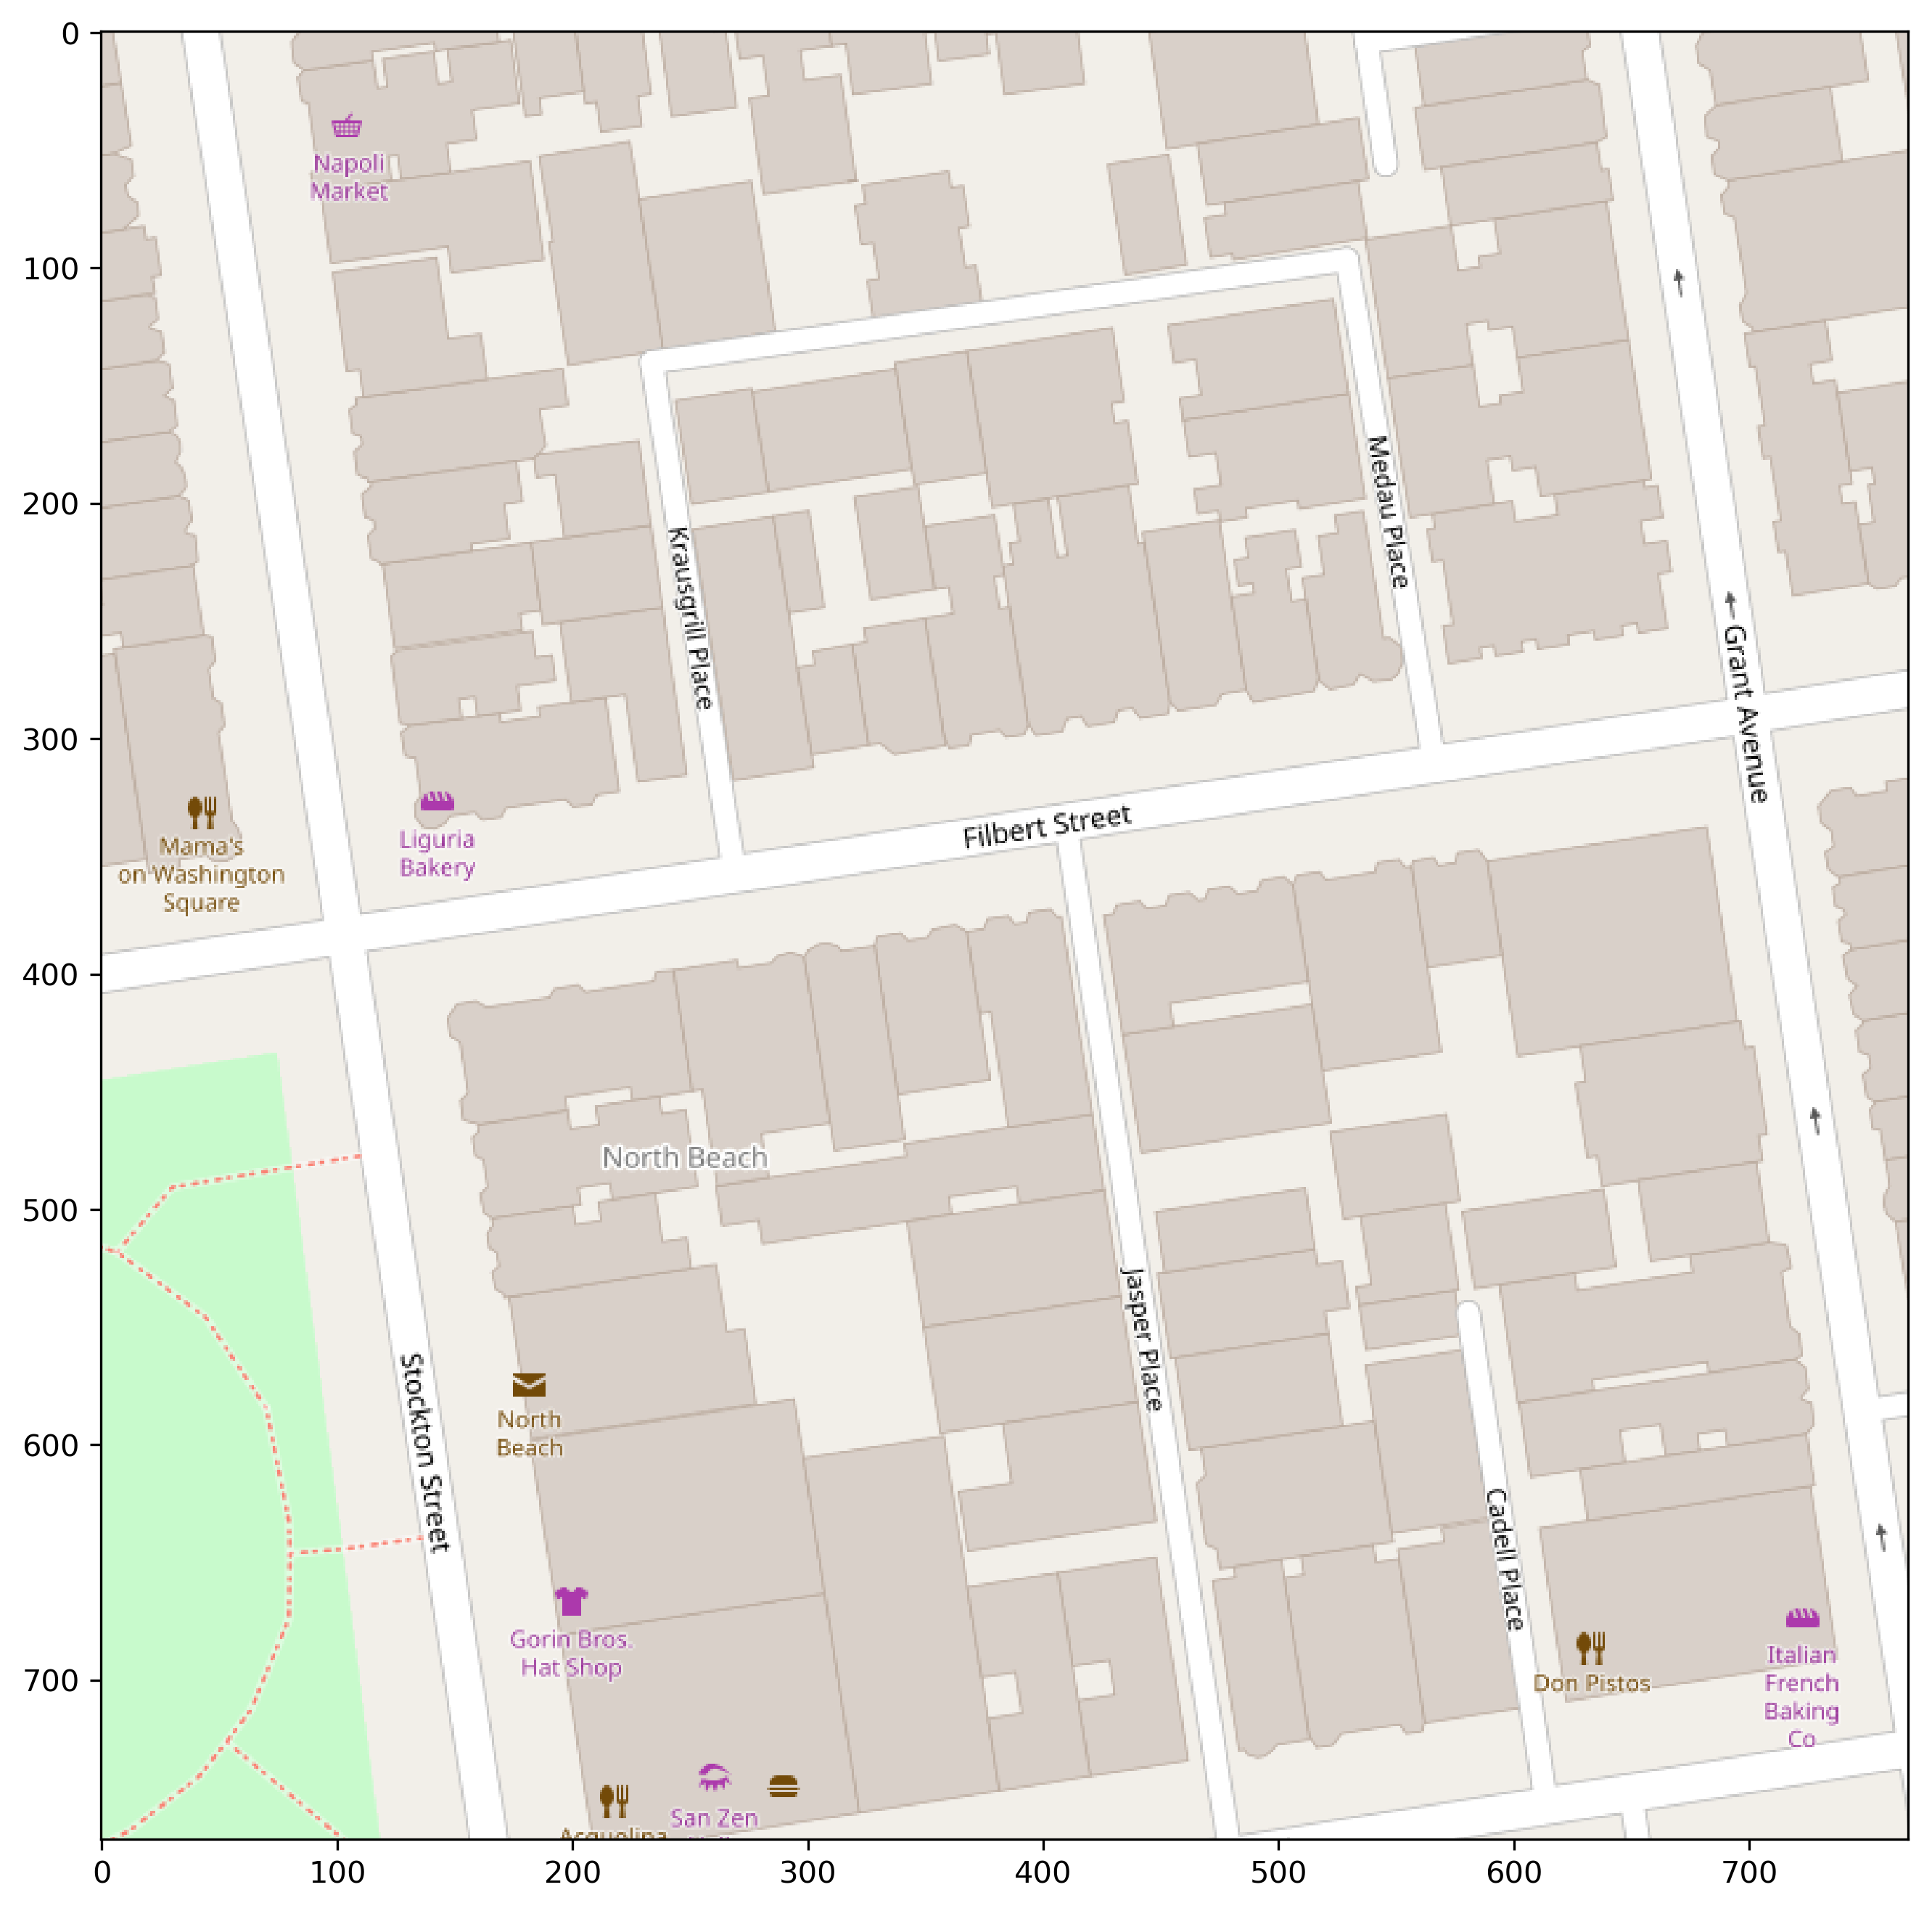

In [39]:
fig = pyplot.figure(figsize=(11, 11), dpi=300)

ratio = 16  # 16
nx = int(768/ratio); ny = int(768/ratio)
myLon=35.698294; myLat=139.77122
myLon=37.801248; myLat=-122.4088656
mapImg, lowImg = getMapFromOSM(myLon, myLat, nx, ny)    # 解像度違いの地図画像
lowImg, lowMask = getMaskFromMap(lowImg)                #  解像度違いのマスク（建物配置）画像
negaMap = 255 - mapImg                                  # 高解像度の地図画像を使い、流体粒子表示用の音が画像を生成・保存
plt.imshow(mapImg)

cv2.imwrite('mapimg.png',mapImg)
cv2.imwrite('lowImg.png',lowImg)
cv2.imwrite('lowMask.png',lowMask)
cv2.imwrite('negaMap.png',negaMap)

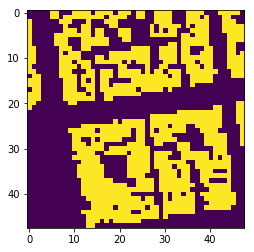

In [40]:
plt.imshow(lowMask)

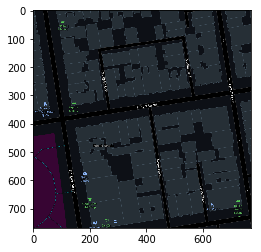

In [41]:
cv2.imwrite('negaMap.png',negaMap)
plt.imshow(negaMap)

In [42]:
# 流体計算

nit = 100
u, v, velocity = doSimulation(nx, ny, wind, lowMask, 'withOutUVMap')

#u, v, velocity, uvmeta, uvImage = doSimulation(nx, ny, wind, lowmask, 'withUVMap')

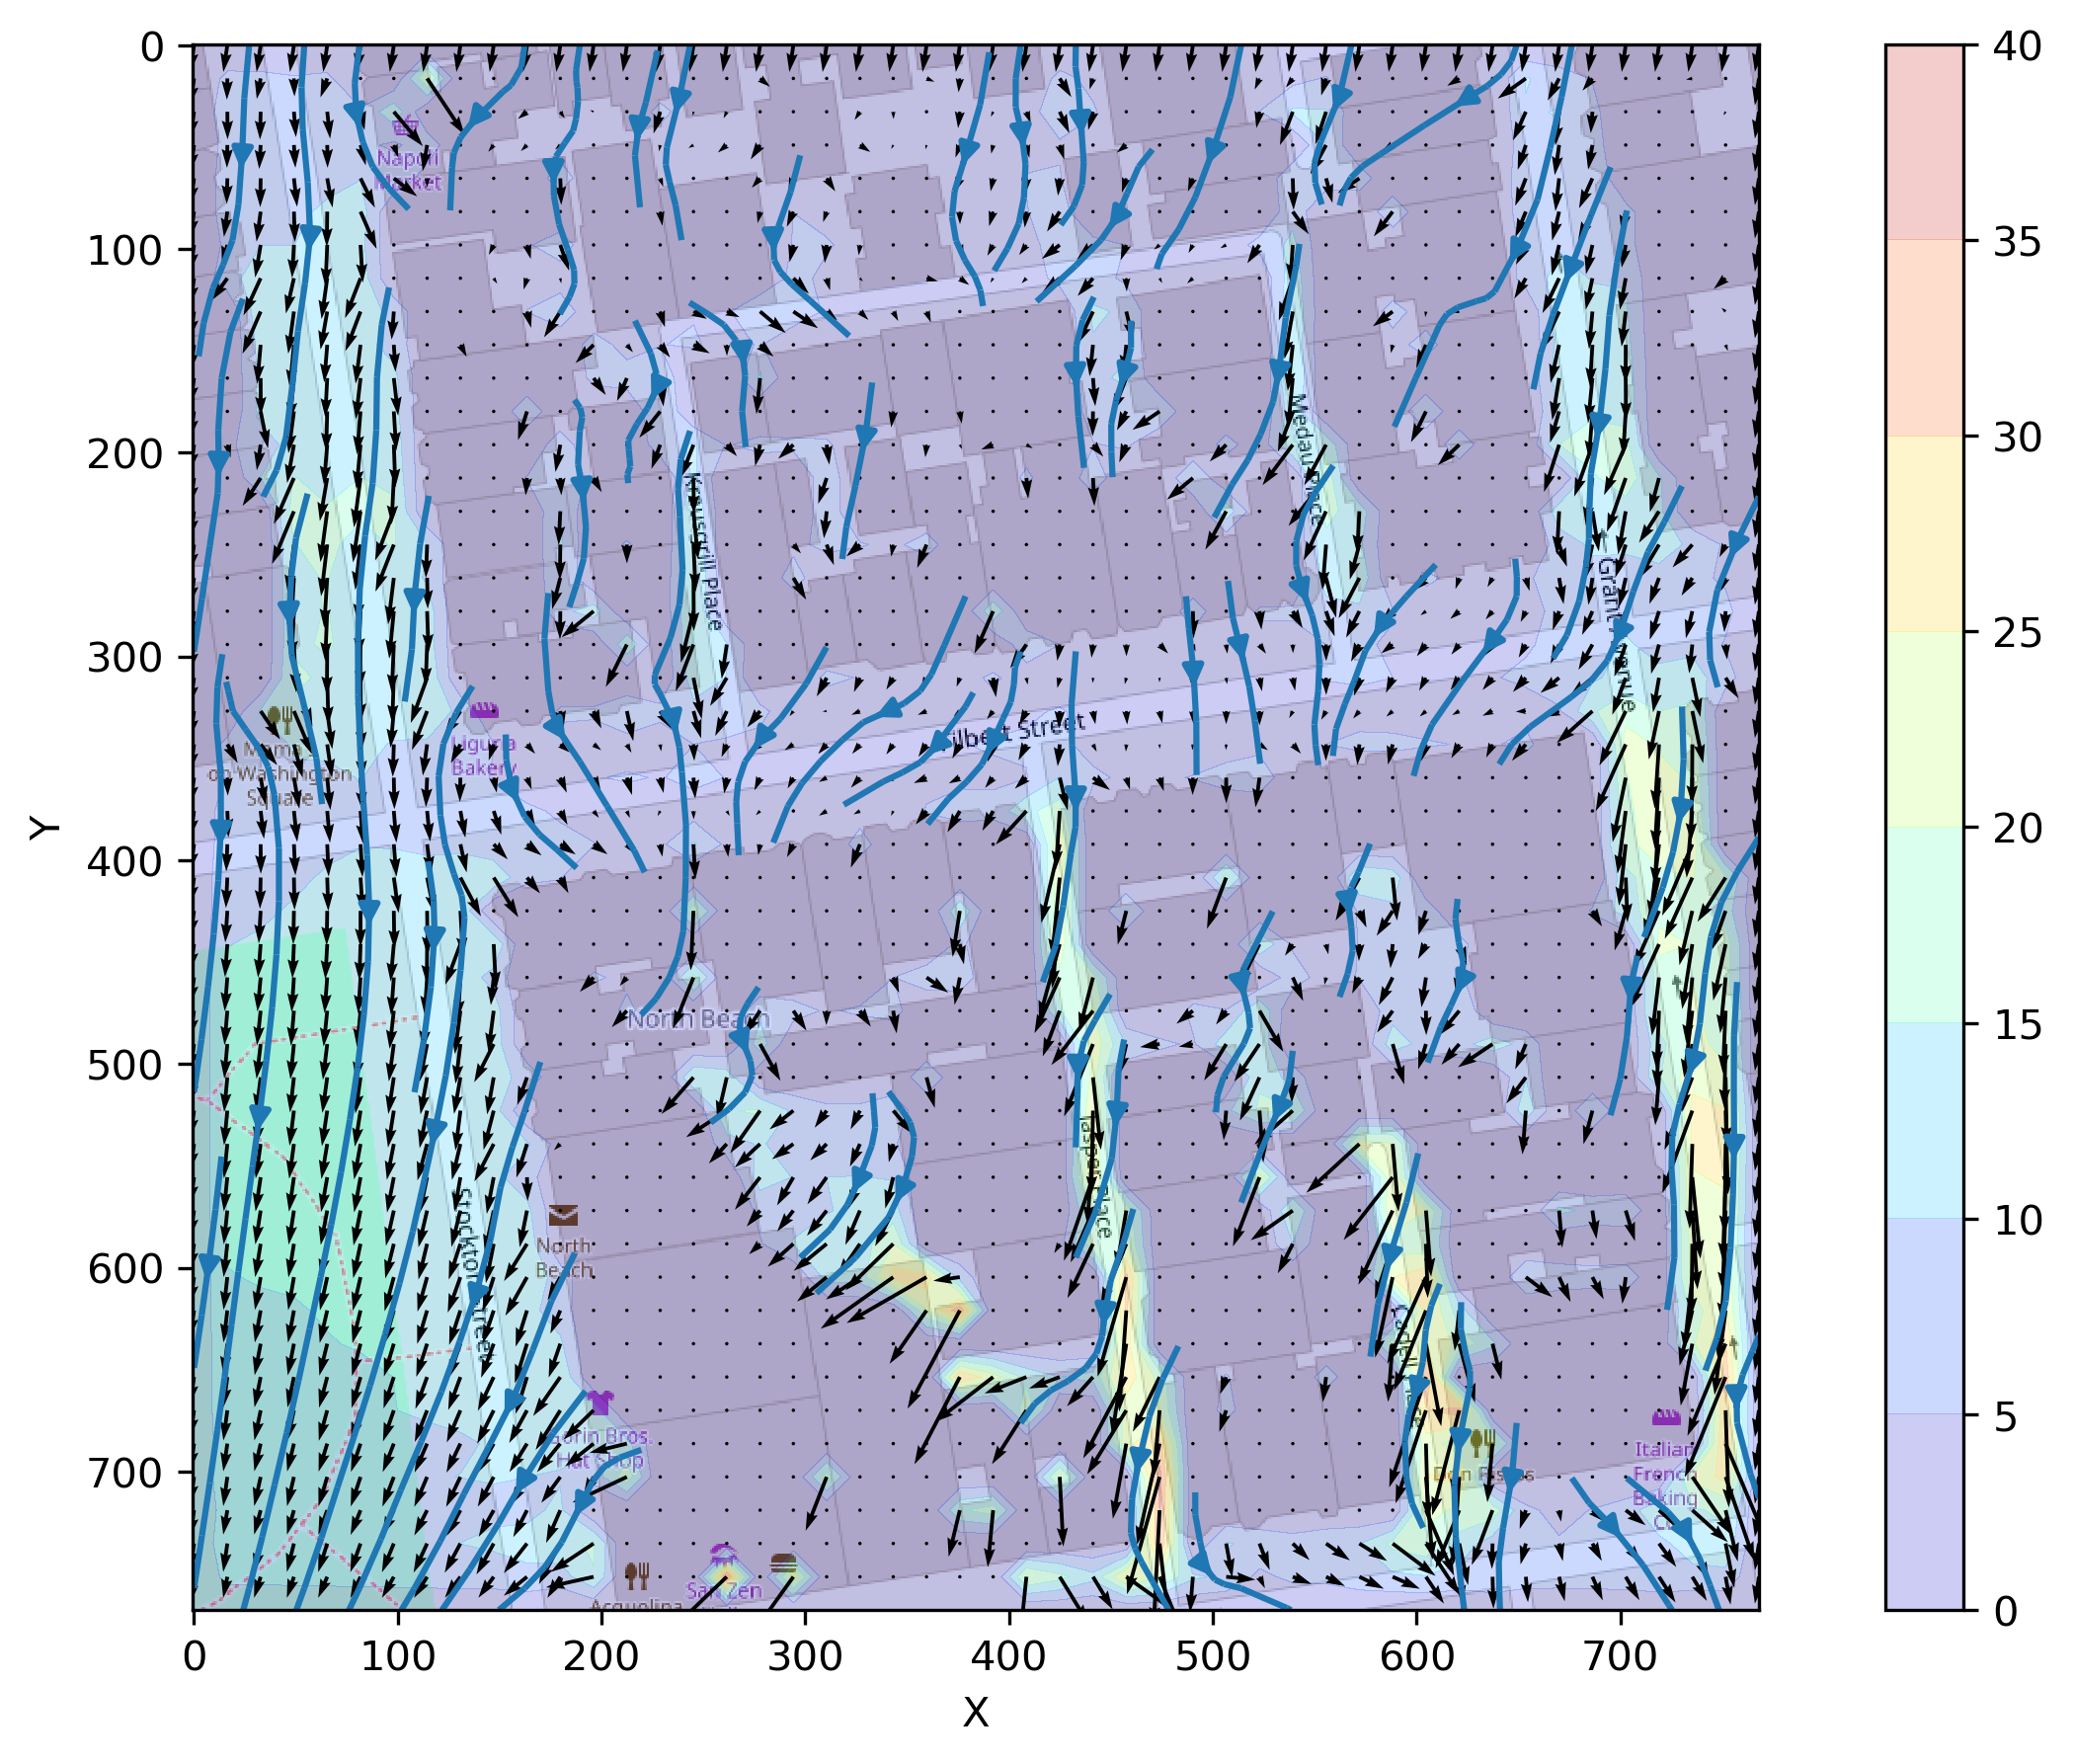

In [44]:
fig = pyplot.figure(figsize=(11, 7), dpi=300)

pyplot.imshow(mapImg)
plotX, plotY = numpy.meshgrid(numpy.linspace(0, nx*ratio, nx),
                              numpy.linspace(0, ny*ratio, ny))
pyplot.contourf(plotX, plotY, velocity, alpha=0.2, cmap=cm.jet) 
# #pyplot.contourf(plotX, plotY, mask, alpha=0.1, cmap=cm.jet)
pyplot.colorbar()
pyplot.quiver(plotX, plotY, u, v)
#pyplot.contour(plotX, plotY, mask, cmap=cm.viridis)
pyplot.streamplot(plotX, plotY, u, -v)
pyplot.xlabel('X'); pyplot.ylabel('Y')

pyplot.savefig('figure1.png')

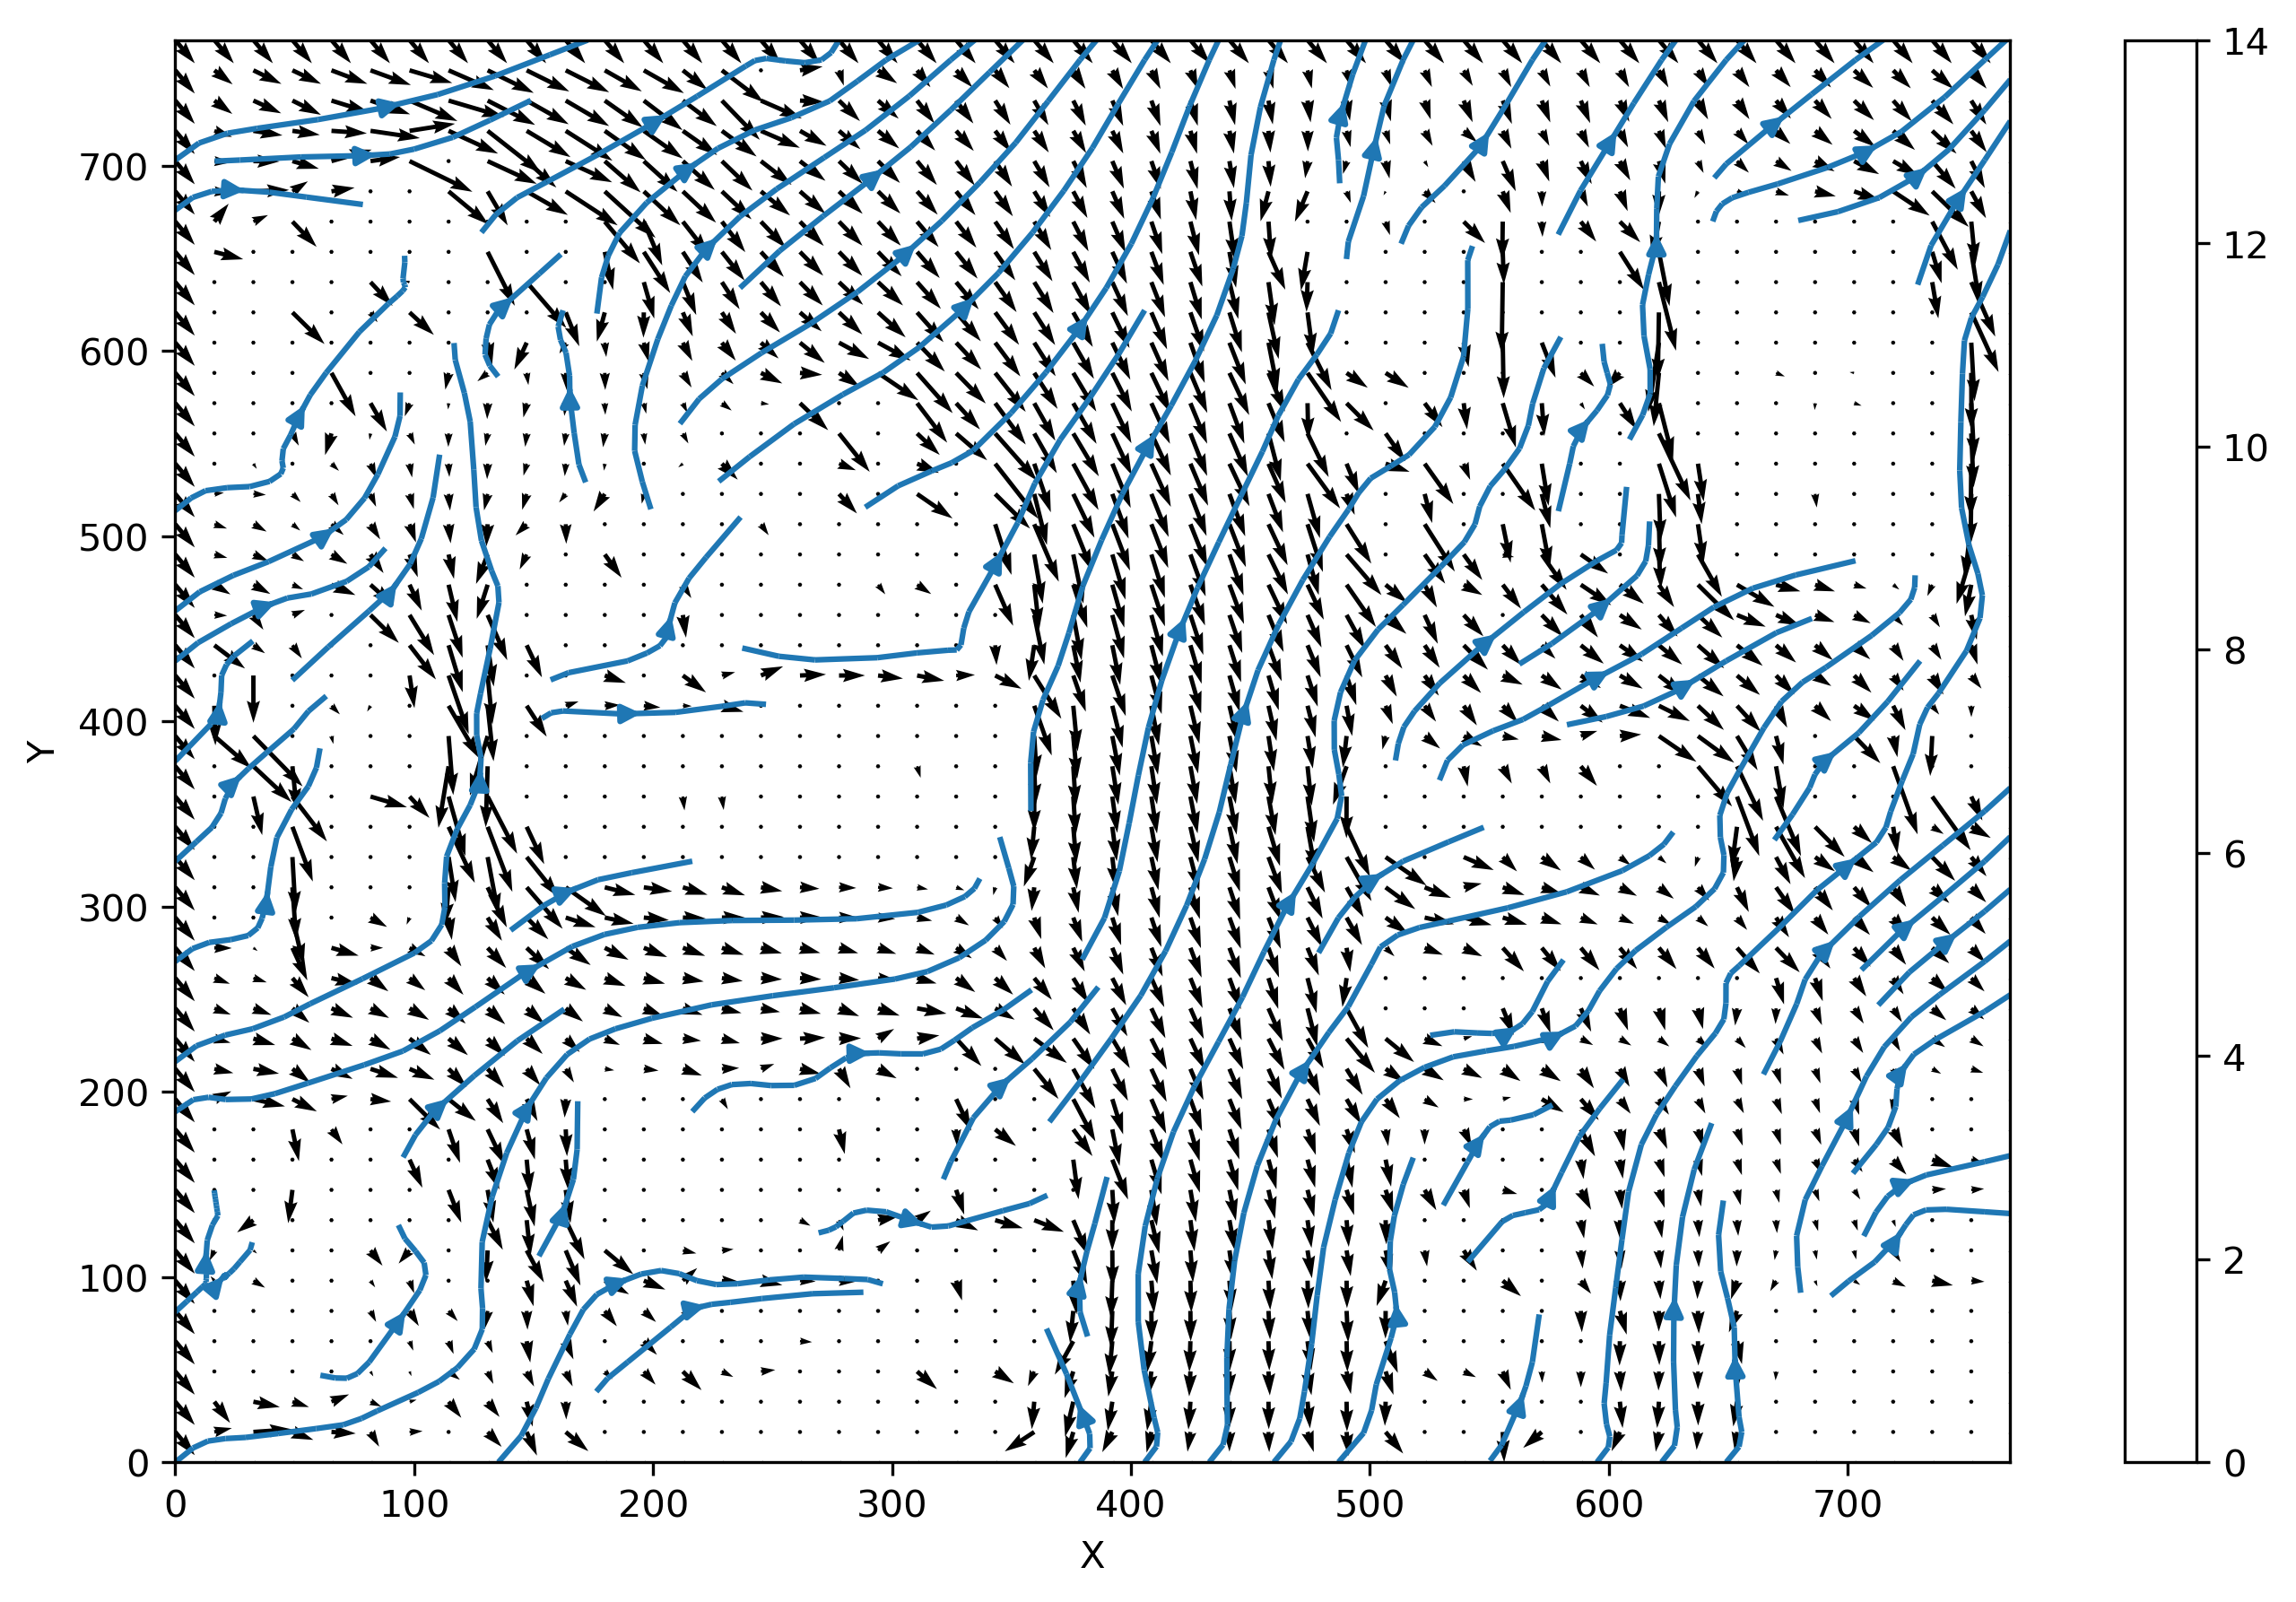

In [23]:
# chart rendering 

fig = pyplot.figure(figsize=(11, 7), dpi=300)
#pyplot.imshow(mapImg)
plotX, plotY = numpy.meshgrid(numpy.linspace(0, nx*ratio, nx),
                              numpy.linspace(0, ny*ratio, ny))
pyplot.contourf(plotX, plotY, velocity, alpha=0.0, cmap=cm.jet)   
# pyplot.contourf(plotX, plotY, mask, alpha=0.1, cmap=cm.jet)
pyplot.colorbar()
pyplot.quiver(plotX, plotY, u, v)                                 
# pyplot.contour(plotX, plotY, mask, cmap=cm.viridis)
pyplot.streamplot(plotX, plotY, u, -v)
pyplot.xlabel('X'); pyplot.ylabel('Y')


pyplot.savefig('figure2.png')

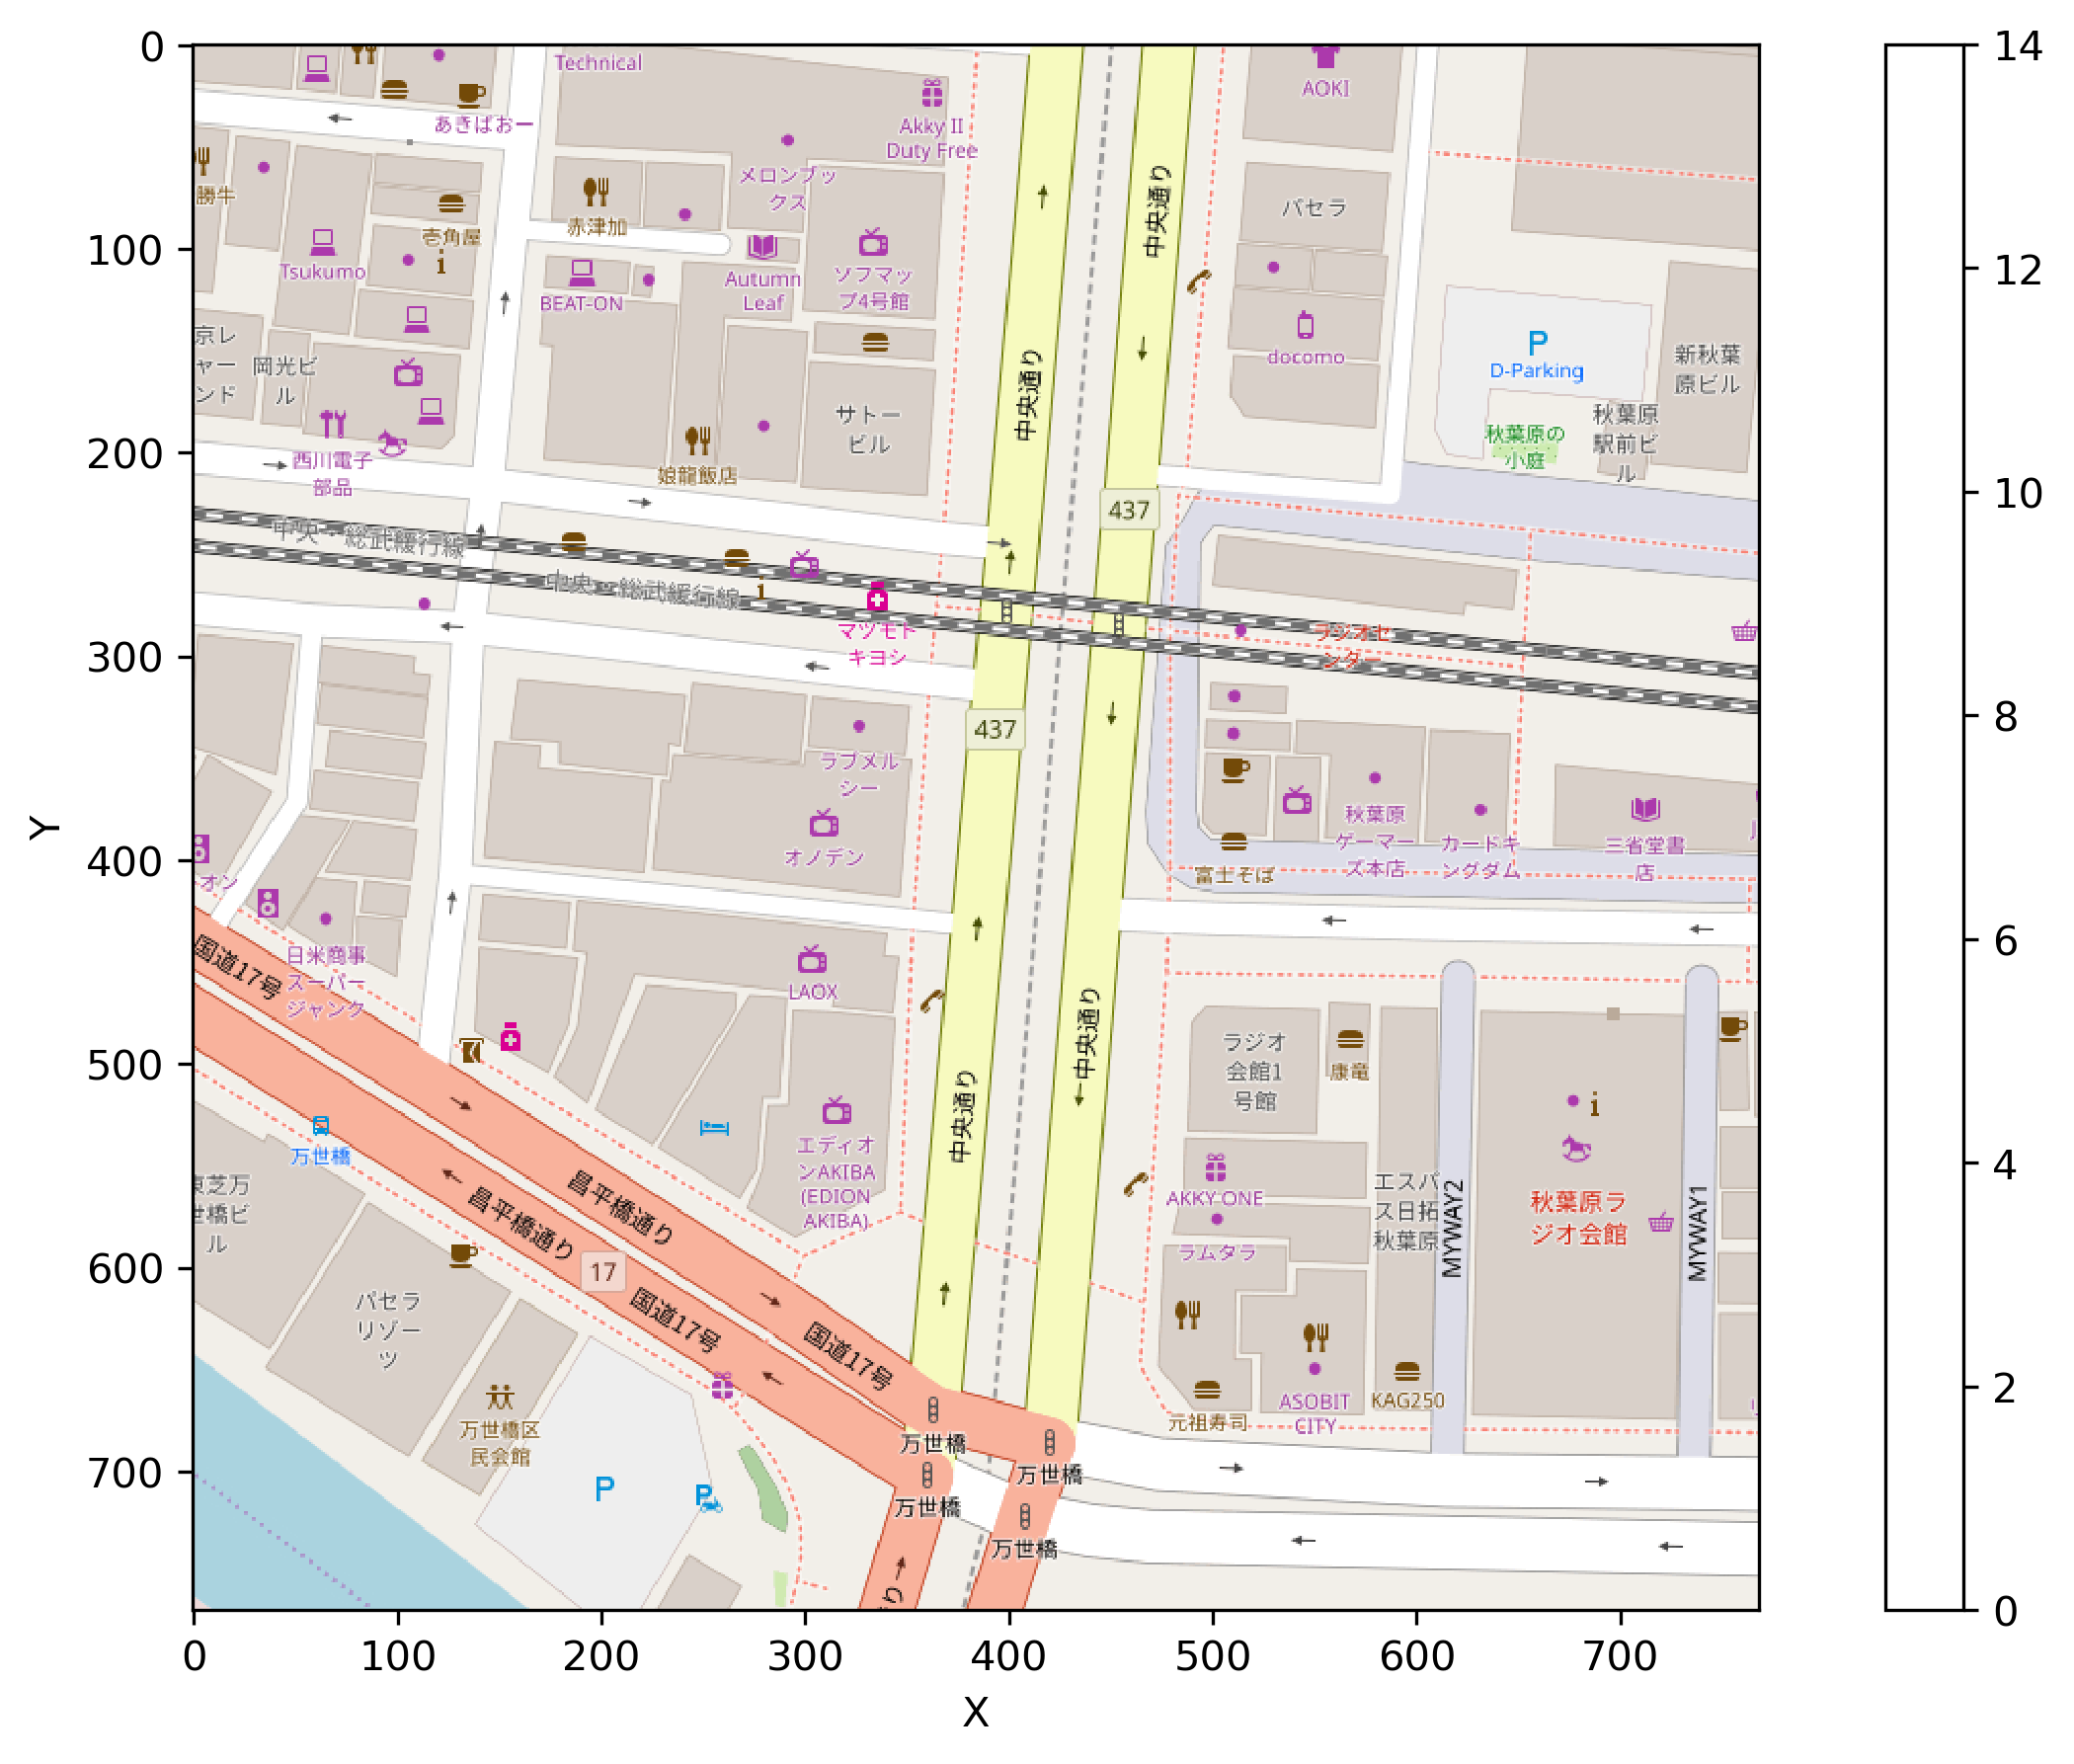

In [24]:
# chart rendering 

fig = pyplot.figure(figsize=(11, 7), dpi=300)

pyplot.imshow(mapImg)
plotX, plotY = numpy.meshgrid(numpy.linspace(0, nx*ratio, nx),
                              numpy.linspace(0, ny*ratio, ny))
pyplot.contourf(plotX, plotY, velocity, alpha=0.0, cmap=cm.jet)   
# pyplot.contourf(plotX, plotY, mask, alpha=0.1, cmap=cm.jet)
pyplot.colorbar()
# pyplot.quiver(plotX, plotY, u, v)                                 
# pyplot.contour(plotX, plotY, mask, cmap=cm.viridis)
# pyplot.streamplot(plotX, plotY, u, -v)
pyplot.xlabel('X'); pyplot.ylabel('Y')

pyplot.savefig('figure3.png')

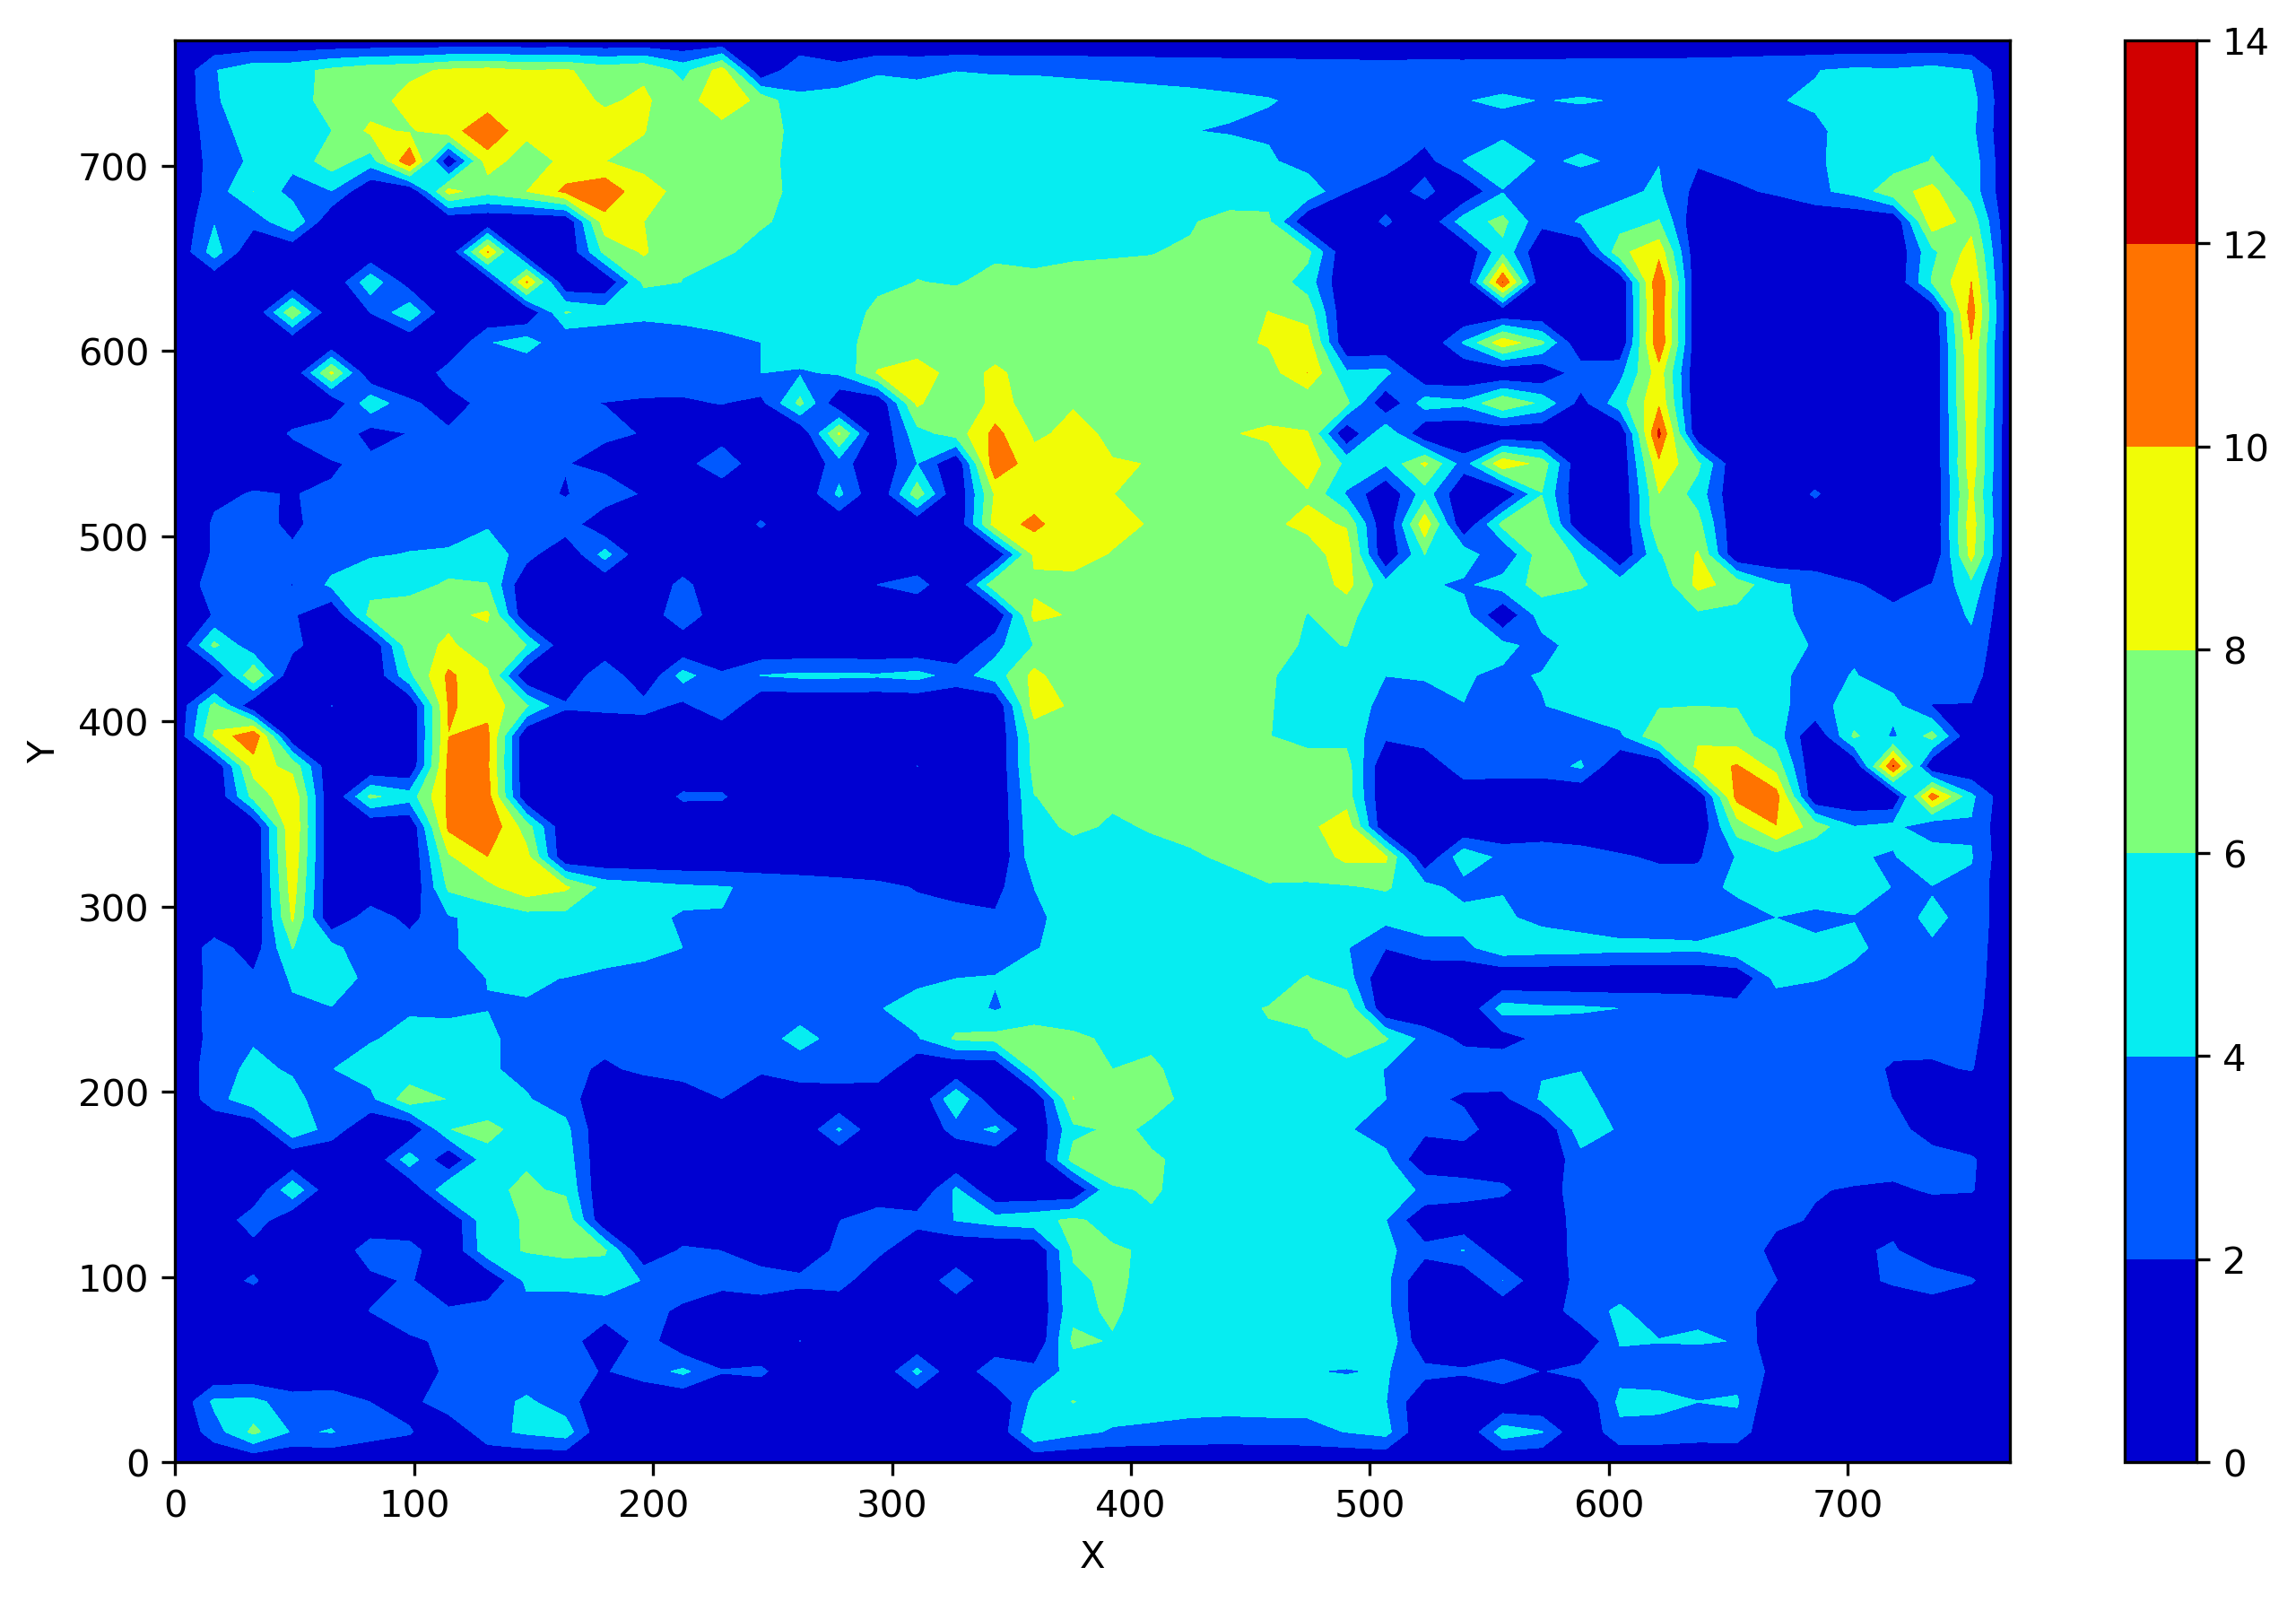

In [25]:
# chart rendering 

fig = pyplot.figure(figsize=(11, 7), dpi=300)

#pyplot.imshow(mapImg)
plotX, plotY = numpy.meshgrid(numpy.linspace(0, nx*ratio, nx),
                              numpy.linspace(0, ny*ratio, ny))
pyplot.contourf(plotX, plotY, velocity, alpha=1.0, cmap=cm.jet)   
# pyplot.contourf(plotX, plotY, mask, alpha=0.1, cmap=cm.jet)
pyplot.colorbar()
# pyplot.quiver(plotX, plotY, u, v)                                 
# pyplot.contour(plotX, plotY, mask, cmap=cm.viridis)
# pyplot.streamplot(plotX, plotY, u, -v)
pyplot.xlabel('X'); pyplot.ylabel('Y')

pyplot.savefig('figure4.png')

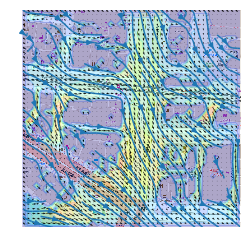

In [32]:
# chart rendering 

#fig = pyplot.figure(figsize=(11, 7), dpi=100)
fig = pyplot.imshow(mapImg)

plotX, plotY = numpy.meshgrid(numpy.linspace(0, nx*ratio, nx),
                              numpy.linspace(0, ny*ratio, ny))

#pyplot.contourf(plotX, plotY, mask, alpha=0.1, cmap=cm.jet)
pyplot.contourf(plotX, plotY, velocity, alpha=0.2, cmap=cm.jet)
#pyplot.colorbar()
#pyplot.contour(plotX, plotY, mask, cmap=cm.viridis)
pyplot.quiver(plotX, plotY, u, v) 
pyplot.streamplot(plotX, plotY, u, -v)
#pyplot.xlabel('X')
#pyplot.ylabel('Y');
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#plt.savefig('pict.png', bbox_inches='tight', pad_inches = 0)